In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
5

In [0]:
!pip install fiona
!pip install rasterio

In [0]:
import sys
sys.path.append('/content/drive/My Drive/Weak_Learners_ML2020')

In [0]:
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torchvision.transforms.functional as F
from sklearn.utils import shuffle
import numbers
from torch.utils.data import Dataset, DataLoader
import utils2   ###############################3
from utils2 import get_accuracy, Monitor, set_random_seeds, f1_score_ ##############

In [0]:
from sklearn.model_selection import train_test_split
import random
from torchvision import transforms 
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

class RandomAffine(object):
    """Random affine transformation of the image keeping center invariant

    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees). Set to 0 to deactivate rotations.
        translate (tuple, optional): tuple of maximum absolute fraction for horizontal
            and vertical translations. For example translate=(a, b), then horizontal shift
            is randomly sampled in the range -img_width * a < dx < img_width * a and vertical shift is
            randomly sampled in the range -img_height * b < dy < img_height * b. Will not translate by default.
        scale (tuple, optional): scaling factor interval, e.g (a, b), then scale is
            randomly sampled from the range a <= scale <= b. Will keep original scale by default.
        shear (sequence or float or int, optional): Range of degrees to select from.
            If shear is a number, a shear parallel to the x axis in the range (-shear, +shear)
            will be apllied. Else if shear is a tuple or list of 2 values a shear parallel to the x axis in the
            range (shear[0], shear[1]) will be applied. Else if shear is a tuple or list of 4 values,
            a x-axis shear in (shear[0], shear[1]) and y-axis shear in (shear[2], shear[3]) will be applied.
            Will not apply shear by default
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter. See `filters`_ for more information.
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        fillcolor (tuple or int): Optional fill color (Tuple for RGB Image And int for grayscale) for the area
            outside the transform in the output image.(Pillow>=5.0.0)

    .. _filters: https://pillow.readthedocs.io/en/latest/handbook/concepts.html#filters

    """

    def __init__(self, degrees, translate=None, scale=None, shear=None, resample=False, fillcolor=0):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
            if degrees == 0:
                self.degrees = 0 
        else:
            assert isinstance(degrees, (tuple, list)) and len(degrees) == 2, \
                "degrees should be a list or tuple and it must be of length 2."
            self.degrees = degrees

        if translate is not None:
            assert isinstance(translate, (tuple, list)) and len(translate) == 2, \
                "translate should be a list or tuple and it must be of length 2."
            for t in translate:
                if not (0.0 <= t <= 1.0):
                    raise ValueError("translation values should be between 0 and 1")
        self.translate = translate

        if scale is not None:
            assert isinstance(scale, (tuple, list)) and len(scale) == 2, \
                "scale should be a list or tuple and it must be of length 2."
            for s in scale:
                if s <= 0:
                    raise ValueError("scale values should be positive")
        self.scale = scale

        if shear is not None:
            if isinstance(shear, numbers.Number):
                if shear < 0:
                    raise ValueError("If shear is a single number, it must be positive.")
                self.shear = (-shear, shear)
            else:
                assert isinstance(shear, (tuple, list)) and \
                    (len(shear) == 2 or len(shear) == 4), \
                    "shear should be a list or tuple and it must be of length 2 or 4."
                # X-Axis shear with [min, max]
                if len(shear) == 2:
                    self.shear = [shear[0], shear[1], 0., 0.]
                elif len(shear) == 4:
                    self.shear = [s for s in shear]
        else:
            self.shear = shear

        self.resample = resample
        self.fillcolor = fillcolor

    @staticmethod
    def get_params(degrees, translate, scale_ranges, shears, img_size):
        """Get parameters for affine transformation

        Returns:
            sequence: params to be passed to the affine transformation
        """
        
        if degrees == 0:
            angle = 0
        else:    
            angle = random.uniform(degrees[0], degrees[1])
            
        if translate is not None:
            max_dx = translate[0] * img_size[0]
            max_dy = translate[1] * img_size[1]
            translations = (np.round(random.uniform(-max_dx, max_dx)),
                            np.round(random.uniform(-max_dy, max_dy)))
        else:
            translations = (0, 0)

        if scale_ranges is not None:
            scale = random.uniform(scale_ranges[0], scale_ranges[1])
        else:
            scale = 1.0

        if shears is not None:
            if len(shears) == 2:
                shear = [random.uniform(shears[0], shears[1]), 0.]
            elif len(shears) == 4:
                shear = [random.uniform(shears[0], shears[1]),
                         random.uniform(shears[2], shears[3])]
        else:
            shear = 0.0

        return angle, translations, scale, shear

    def __call__(self, img):
        """
            img (PIL Image): Image to be transformed.

        Returns:
            PIL Image: Affine transformed image.
        """

        ret = self.get_params(self.degrees, self.translate, self.scale, self.shear, img[0].shape)
        
        if ret[0] == 0:
            total_img = []
            for m in img:
                m = np.array([m])
                m1 = torch.tensor(m, dtype=torch.float32)
                m2 = transforms.ToPILImage()(m1)
                m_crop = transforms.CenterCrop(m2.size[0]//2)(m2)
                m3 = transforms.ToTensor()(m_crop)
                m_np = np.array(m3.tolist())[0]
                total_img.append(m_np)
                
            total_img_np = np.array(total_img)
            return np.array(total_img_np)
            
        else:
            total_img = []
            for c in img:
                c = np.array([c])
                c1 = torch.tensor(c, dtype=torch.float32)
                c2 = transforms.ToPILImage()(c1)
                af = F.affine(c2, *ret, resample=self.resample, fillcolor=self.fillcolor)
                af_crop = transforms.CenterCrop(af.size[0]//2)(af)
                af1 = transforms.ToTensor()(af_crop)
                af_np = np.array(af1.tolist())[0]
                total_img.append(af_np)

            total_img_np = np.array(total_img)

            return total_img_np

    def __repr__(self):
        s = '{name}(degrees={degrees}'
        if self.translate is not None:
            s += ', translate={translate}'
        if self.scale is not None:
            s += ', scale={scale}'
        if self.shear is not None:
            s += ', shear={shear}'
        if self.resample > 0:
            s += ', resample={resample}'
        if self.fillcolor != 0:
            s += ', fillcolor={fillcolor}'
        s += ')'
        d = dict(self.__dict__)
        d['resample'] = _pil_interpolation_to_str[d['resample']]
        return s.format(name=self.__class__.__name__, **d)


In [0]:
import scipy
import numpy as np
import seaborn as sns
import fiona
import rasterio
import matplotlib.pyplot as plt

from shapely import geometry
from rasterio.mask import mask
from tqdm import tqdm_notebook
from extractor_helper import extractor


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class TreesData():
    def __init__(self, X, y, transform, duplicate={}):
        super().__init__()
        
        self.transform = transform
        
        for k, v in duplicate.items():
          idx = y == k
          X = np.concatenate([X, np.repeat(X[idx], int(v), 0)])
          y = np.concatenate([y, np.repeat(y[idx], int(v), 0)])
        self.X, self.y = shuffle(X, y)


        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.transform(self.X[idx])
        y = self.y[idx]

        
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

## Inference

In [0]:
test2_img = rasterio.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test2/pp_2_sat_modified.tif")
test2_points = fiona.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test2/points_2_modified_Copy.shp", "r")

test3_img = rasterio.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test3/pp_3_sat_modified.tif")
test3_points = fiona.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test3/targets_Copy.shp", "r")

test4_img = rasterio.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test4/pp_4_sat_modified_spline.tif")
test4_points = fiona.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test4/modified_points_Copy.shp", "r")


In [0]:
from extractor_helper import extractor
size___ = 14
patch2,coordinates2,labels2, = extractor(test2_img,test2_points,size___ ,normalize=True,labeling=True)
patch3,coordinates3,labels3, = extractor(test3_img,test3_points,size___ ,normalize=True,labeling=True)
patch4,coordinates4,labels4, = extractor(test4_img,test4_points,size___ ,normalize=True,labeling=True)

None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coord

In [0]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

patch2,patch3, patch4 = np.array(patch2), np.array(patch3), np.array(patch4)
print(patch2.shape)
labels2, labels3, labels4 = np.array(labels2), np.array(labels3), np.array(labels4)
patch2, patch3, patch4 = np.moveaxis(patch2,3,1), np.moveaxis(patch3,3,1), np.moveaxis(patch4,3,1)
print(patch2.shape)
patch = np.concatenate((patch2, patch3, patch4),axis=0)
labels = np.concatenate((labels2,labels3,labels4),axis=0)

print(patch.shape)
print(labels.shape)

(455, 28, 28, 8)
(455, 8, 28, 28)
(1012, 8, 28, 28)
(1012,)


In [0]:
weight_0 = len(labels) / np.sum(labels == 0)
weight_1 = len(labels) / np.sum(labels == 1)
weight_2 = len(labels) / np.sum(labels == 2)
weight_3 = len(labels) / np.sum(labels == 3)
print(weight_0, weight_1, weight_2, weight_3)
duplicate1 = {0: round(weight_0 - 1), 1: round(weight_1 - 1), 2: round(weight_2 -1), 3: round(weight_3 -1)}
weight = np.array([weight_0, weight_1, weight_2, weight_3])
weight = weight / np.sum(weight) # normalized, just in case this is not done automatically

duplicate1

1.9536679536679538 3.212698412698413 24.095238095238095 7.386861313868613


{0: 1.0, 1: 2.0, 2: 23.0, 3: 6.0}

In [0]:
x_train,x_test,y_train,y_test = train_test_split(patch, labels, test_size=.2, shuffle=True, random_state = 12)

<class 'numpy.ndarray'>


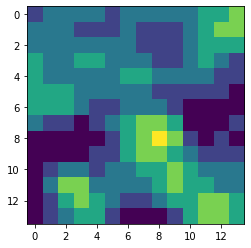

In [0]:
sam = x_train[0].copy()
print(type(sam))
sss = RandomAffine(degrees = 0)(sam)
type(sss[0])
plt.imshow(sss[0,:,:])


<class 'numpy.ndarray'>


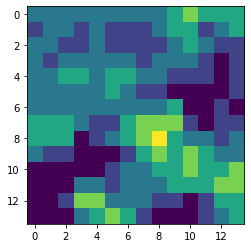

In [0]:
sam = x_train[0].copy()
print(type(sam))
sss = RandomAffine(degrees = 20)(sam)
type(sss[0])
plt.imshow(sss[0,:,:])

In [0]:
train_data = TreesData(x_train,y_train, RandomAffine(degrees = 60, translate = (0.1, 0.2), shear = 20), duplicate1)
test_data = TreesData(x_test,y_test,RandomAffine(degrees = 0))

In [0]:
train_loader = torch_data.DataLoader(train_data,batch_size=64, shuffle=True)
val_loader = torch_data.DataLoader(test_data,batch_size=250,shuffle=True)

In [0]:
new_train = []
j=0
for a,b in train_data:
    new_train.append(b.tolist())
    j+=1


import seaborn as sns
sns.countplot(np.array(new_train))

In [0]:
import torch
import torch.nn as nn


__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):  # 256 * 7 * 7

    def __init__(self, features, num_classes=4, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(16384, 4096),  
            nn.ReLU(True),
            nn.Dropout(p=0.01),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 128),
            nn.ReLU(True),
            nn.Linear(128, num_classes),
            nn.ReLU(True)
        
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        #print(x.shape)
        x = self.features(x)
        #print(x.shape)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.classifier(x)
        
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 8
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, padding=1)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=2, padding=1, stride=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {'A': [32, 64, 'M', 128, 128, 'M', 256, 256]}

def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs) #, batch_norm=batch_norm
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def vgg11(pretrained=False, progress=True, **kwargs):
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11', 'A', True, pretrained, progress, **kwargs)

model = vgg11(pretrained=False, progress=False)

In [0]:
def train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=1, plot_each=10):
    # send the model to that device
    model = model.to(device)
    # initialize some visualization code that you don't need to care about
    monitor = Monitor()
    # Reduce the lr every 50 epochs
    #scheduler = StepLR(optimizer, 50, 0.5, last_epoch=-1)
    # one full cycle on train data is called epoch
    for epoch in trange(epochs_n):
        # switch the model to the train mode
        # later on we will have some blocks that behave differently in train and test mode
        model.train()
        for model_input, target in train_loader:
            # send data to device
            model_input = model_input.to(device)
            target = target.to(device)
            # calculate outputs and loss
            model_output = model(model_input)
            loss = loss_function(model_output, target)
            # update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # do some visualization
            monitor.add_loss_value(loss.item())
        
        # evaluate our model
        model.eval()
        train_accuracy = get_accuracy(model, train_loader, device)
        val_accuracy = get_accuracy(model, val_loader, device)

        val_f1 = f1_score_(model, val_loader, device)  ###########

        monitor.add_train_accuracy_value(train_accuracy)
        monitor.add_val_accuracy_value(val_accuracy)
        monitor.add_val_f1_value(val_f1)  ##############

    
        #scheduler.step()
        
        if epoch % plot_each == 0:
            monitor.show()

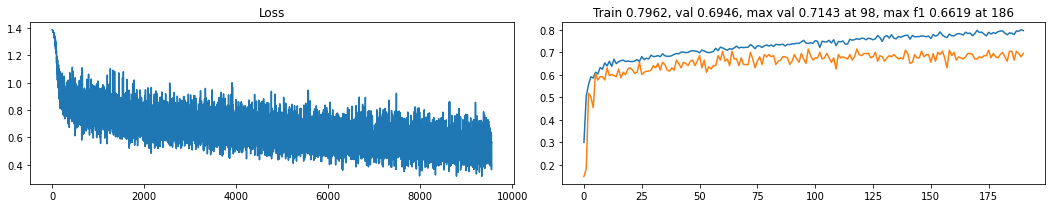

100%|██████████| 200/200 [49:33<00:00, 14.87s/it]


In [0]:
#from utils import get_accuracy, Monitor, set_random_seeds
from tqdm import trange

loss_function = torch.nn.CrossEntropyLoss()  # weight = torch.tensor(weight, dtype=torch.float32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)#torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# train
train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=200)